In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scvelo as scv
import FRED
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
print("Using device", device)
sns.set_theme()
%load_ext autoreload
%autoreload 2

Using device mps


# 05h Single Cell Dataset Benchmarker with PHATE
> Run FRED on a specified single cell dataset, using UMAP embeddings

This is set up for the popular library `papermill`, which can parameterize and execute notebooks. 

First, we set the notebook-wide parameters, then run the cells. Papermill will create copies of the notebook with each parameter configuration given.

In [ ]:
notebook = "05h Single Cell Dataset Benchmarker with PHATE base"
dataset_name = "pancreas"
sigma = 'automatic'
flow_strength = 1
smoothness_weight = 0
flow_neighbor_loss_weight = 1
contrastive_flow_loss_weight = 1
contrastive_loss_weight = 0
diffdist_weight = 100
num_neighbors = 5

# Set Up

In [ ]:
# Load single cell dataset from scvelo and get associated information
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, rnavelo_pcs
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
import os
from pathlib import Path
import scvelo


# choose correct dataset
Xpath = f"../../data/{dataset_name}/processed/X.txt"
if os.path.exists(Xpath):
    X = np.loadtxt(Xpath)
    flow = np.loadtxt(f"../../data/{dataset_name}/processed/flow.txt")
    labels = np.loadtxt(f"../../data/{dataset_name}/processed/labels.txt")
    latent_time = np.loadtxt(f"../../data/{dataset_name}/processed/latent_time.txt")
else:
    if dataset_name == "bone marrow":
        adata = scv.datasets.bonemarrow()
    elif dataset_name == "dentategyrus":
        adata = scv.datasets.dentategyrus()
    elif dataset_name == "pancreas":
        adata = scv.datasets.pancreas()
    elif dataset_name == "dentategyrus_lamanno":
        adata = scv.datasets.dentategyrus_lamanno()
    print("processing data with pcs")
    X, flow, labels, n_pcs = rnavelo_pcs(adata)
    # dynamical recovery
    scv.tl.recover_dynamics(adata, n_jobs=7)
    scv.tl.latent_time(adata)
    latent_time = adata.obs['latent_time'].to_numpy()
    # save the processed data to np txt files for ready loading in the future
    Path(f"data/{dataset_name}/processed").mkdir(parents = True,exist_ok=True)
    np.savetxt(f"data/{dataset_name}/processed/X.txt",X)
    np.savetxt(f"data/{dataset_name}/processed/flow.txt",flow)
    np.savetxt(f"data/{dataset_name}/processed/labels.txt",labels)
    np.savetxt(f"data/{dataset_name}/processed/latent_time.txt",latent_time)


Set sigma =  8.403331
Computing PHATE with phate_decay=40 and self.n_neighbors=5
X is tensor([[-13.6794,  14.4443,  -2.0508,  ...,   1.5196,   1.7939,   0.5915],
        [ -2.0034,  -4.4326,   6.7553,  ...,   0.9907,   0.4587,   0.2311],
        [-12.2434,  16.4074,  -1.5515,  ...,  -1.8877,   0.4154,  -0.5711],
        ...,
        [  0.3926,  -2.5394,   9.8178,  ...,  -2.0105,  -0.3223,   0.2489],
        [-10.9474,  11.4025,  -5.8244,  ...,   0.4090,   0.7200,   0.2548],
        [-12.9658,  15.5302,  -4.2545,  ...,  -0.2912,  -0.5371,  -1.3741]])
Calculating PHATE...
  Running PHATE on 3696 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.25 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.27 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.26 seconds.
    Calculating KMeans.

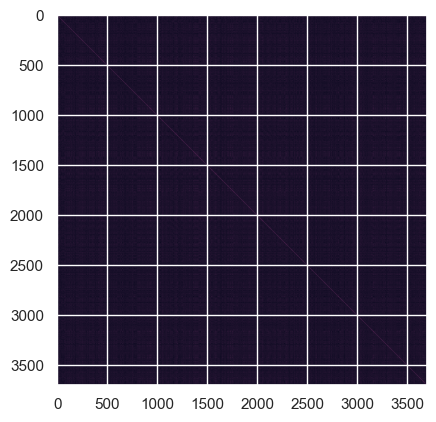

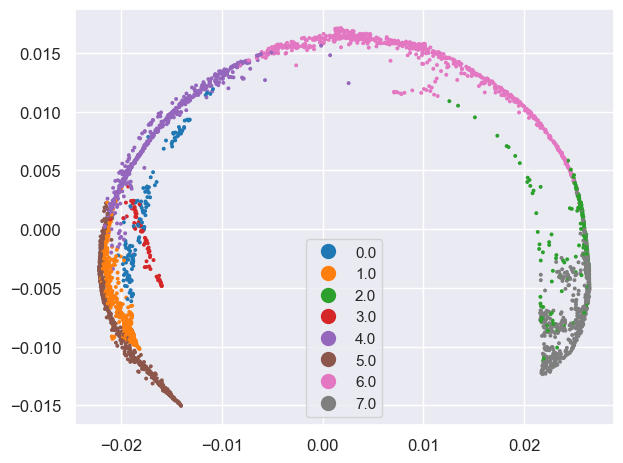

In [ ]:
# build dataset
ds = ManifoldWithVectorField(X, flow, labels, sigma=sigma, nbhd_strategy="flow neighbors", n_neighbors=num_neighbors, flow_strength = flow_strength, prior_embedding="PHATE")
dataloader = DataLoader(ds, batch_size=None, shuffle=True)

## Set up the model

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points, Trainer
title = notebook.replace('.ipynb','').replace("/","-")
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[X.shape[1], 20, 10, 5, 2],
            device=device,
            sigma=5,
            flow_strength=1,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 0,
            "distance regularization": diffdist_weight,
            "kld": 0,
            "smoothness": smoothness_weight,
            "flow neighbor loss": flow_neighbor_loss_weight,
            "contrastive flow loss": contrastive_flow_loss_weight,
            "contrastive loss":contrastive_loss_weight,
        }
visualization_functions = [
    save_embedding_visualization # just save these, for use in gif making. No visualizations otherwise, to keep it tidy.
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title)

In [ ]:
#papermill_description=FittingFRED
FREDtrainer.fit(dataloader, n_epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [ ]:
torch.max(ds.precomputed_distances)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
  File "/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_16779/786900564.py", line 1, in <module>
    torch.max(ds.precomputed_distances)
              ^^
NameError: name 'ds' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/cor

# Results

In [ ]:
FREDtrainer.visualize_embedding(use_streamlines=False)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
  File "/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_16779/326762505.py", line 1, in <module>
    FREDtrainer.visualize_embedding(use_streamlines=False)
    ^^^^^^^^^^^
NameError: name 'FREDtrainer' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.1

In [ ]:
FREDtrainer.visualize_loss()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
  File "/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_16779/1548061974.py", line 1, in <module>
    FREDtrainer.visualize_loss()
    ^^^^^^^^^^^
NameError: name 'FREDtrainer' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/c

In [ ]:
FREDtrainer.training_gif(duration=150)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
  File "/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_16779/843999407.py", line 1, in <module>
    FREDtrainer.training_gif(duration=150)
    ^^^^^^^^^^^
NameError: name 'FREDtrainer' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/

# Qualitative analyses

We combine the embedded points with their velocities in the embedding space. 

In [ ]:
embedded_points = FREDtrainer.embedded_points.cpu().detach().numpy()
embedded_velocities = FREDtrainer.embedded_velocities.cpu().detach().numpy()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
  File "/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_16779/2680873055.py", line 1, in <module>
    embedded_points = FREDtrainer.embedded_points.cpu().detach().numpy()
                      ^^^^^^^^^^^
NameError: name 'FREDtrainer' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
  File "/Users/adjourner/minifor

In [ ]:
# create unique identifier for notebook
import secrets
import string
alphabet = string.ascii_letters + string.digits
unid = ''.join(secrets.choice(alphabet) for i in range(20))  # for a 20-character password
spread_name = notebook.replace('/','-') + "_dataset_" + dataset_name
unid

'8JxpXI0f7MNOmM5GcgAf'

In [ ]:
from FRED.metrics import comprehensive_flow_metrics
silhouette_score, silhouete_score_with_flow, knn_score, neighbor_score, monotone_score = comprehensive_flow_metrics(
    X = X,
    flows = flow,
    labels = labels,
    embedded_points = embedded_points,
    embedded_velocities = embedded_velocities,
    time_labels = latent_time,
    spreadsheet_name=spread_name,
    unid = unid,
    flow_strength = flow_strength
)
print(f"{silhouette_score=} {silhouete_score_with_flow=} {knn_score=} {neighbor_score=} {monotone_score=}")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
  File "/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_16779/3692624261.py", line 1, in <module>
    from FRED.metrics import comprehensive_flow_metrics
  File "/Users/adjourner/Documents/4 SRC/4.22.3 SUMRY Directed Graphs Project/FRED/FRED/metrics.py", line 9, in <module>
    from .embed import flow_neighbor_loss
  File "/Users/adjourner/Documents/4 SRC/4.22.3 SUMRY Directed Graphs Project/FRED/FRED/embed.py", line 11, in <module>
    from .data_processing import affinity_matrix_from_pointset_to_pointset
  File "/Users/adjourner/Documents/4 SRC/4.22.3 SUMRY Directed Graphs Project/FRED/FRED/data_processing.py", line 227, in <module>
    from sklearn.metrics import pairwise_distances
ModuleNotFoundError: No module named 'sklearn'

During handling of the above exception, another exception occurred:

Trac

In [ ]:
import csv
with open(f"results/{spread_name}.csv", 'a') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(
            [unid,
            sigma,
            flow_strength,
            flow_neighbor_loss_weight,
            contrastive_flow_loss_weight,
            num_neighbors,
            smoothness_weight,
            diffdist_weight,
            silhouette_score,
            silhouete_score_with_flow,
            knn_score,
            neighbor_score, 
            monotone_score,
            ])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
  File "/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_16779/2484851778.py", line 2, in <module>
    with open(f"results/{spread_name}.csv", 'a') as csv_file:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 282, in _modified_open
FileNotFoundError: [Errno 2] No such file or directory: 'results/05h Single Cell Dataset Benchmarker with PHATE base_dataset_pancreas.csv'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-pa

# Save embeddings to txt files

In [ ]:
filename = f"{spread_name} - {dataset_name} - {unid}"
np.savetxt(f'embeddings/{filename} - X.txt',FREDtrainer.embedded_points.detach().cpu().numpy())
np.savetxt(f'embeddings/{filename} - V.txt',FREDtrainer.embedded_velocities.detach().cpu().numpy())

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
  File "/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_16779/147749229.py", line 2, in <module>
    np.savetxt(f'embeddings/{filename} - X.txt',FREDtrainer.embedded_points.detach().cpu().numpy())
                                                ^^^^^^^^^^^
NameError: name 'FREDtrainer' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
  File "/Users/adjourner/miniforge3/envs/flowartist/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1177, in s